# Chapter 01: exercises

In [16]:
import jax
import numpy as np
import pandas as pd
import sympy as sp
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
%config InlineBackend.figure_format = "retina"

## E01
$$
    p(x) = \frac{x^2}{\sqrt{2\pi}}\exp\left(-x^2/2\right)
$$

In [32]:
x = jnp.linspace(-4, 4, 500)

def q(x, vmin=-4, vmax=4):
    y = jnp.ones_like(x)
    return y / (vmax - vmin)

def p(x):
    return x ** 2 / np.sqrt(2 * np.pi) * np.exp(-x ** 2 / 2)


def w(x):
    return p(x) / q(x)

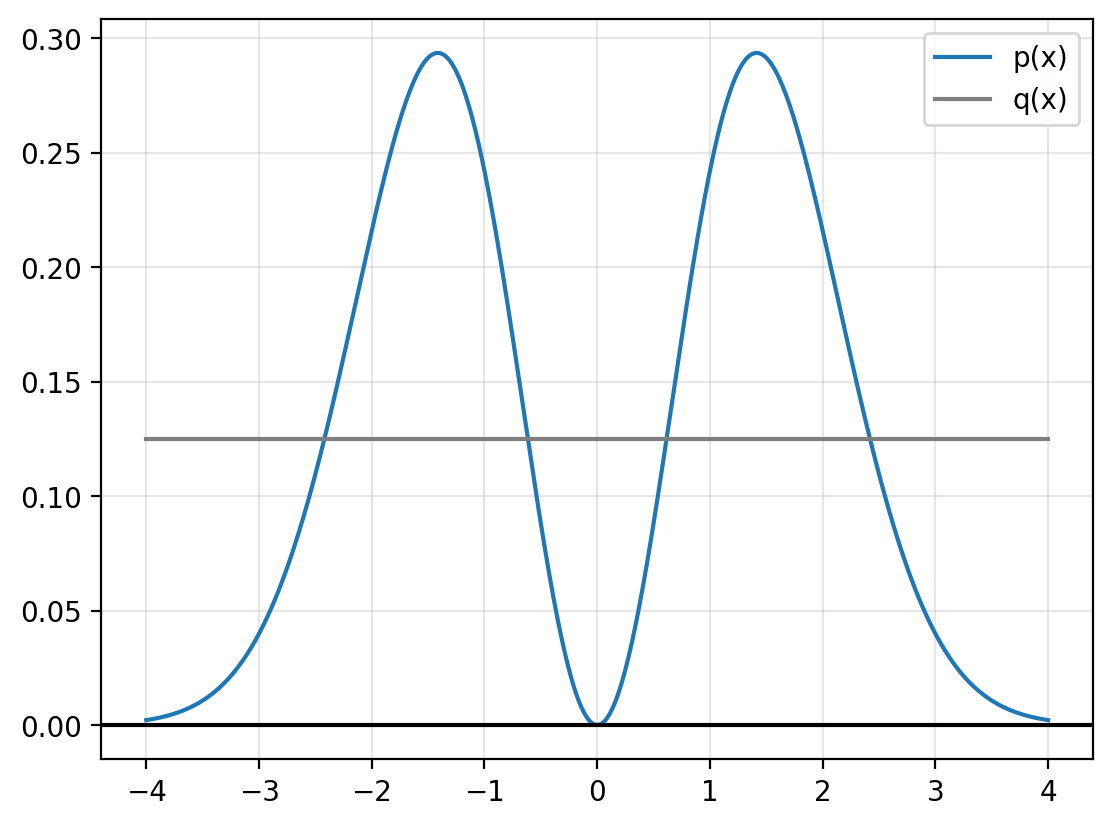

In [35]:
plt.plot(x, p(x), label="p(x)")
plt.plot(x, q(x), c="tab:gray", label="q(x)")
plt.axhline(y=0, c="black")
plt.legend()
plt.grid(alpha=0.3)

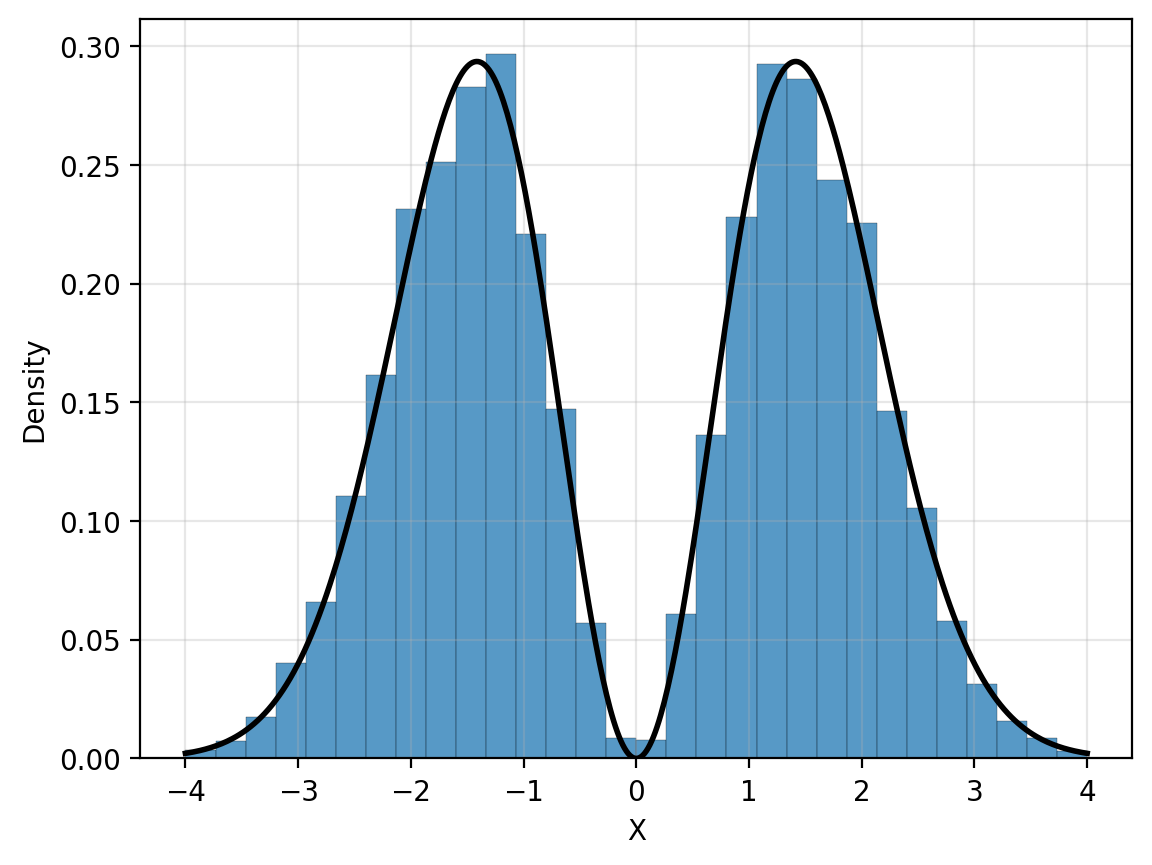

In [36]:
key = jax.random.PRNGKey(314)
n_samples = 10_000
Xq = jax.random.uniform(key, (n_samples,), minval=-4, maxval=4)
weights = w(Xq) / w(Xq).sum()

df = pd.DataFrame({
    "X": np.array(Xq),
    "weights": np.array(weights)
})

sns.histplot(data=df, x="X", weights="weights", bins=30, stat="density", linewidth=0.1)
plt.plot(x, p(x), label="p(x)", c="black", linewidth=2)
plt.grid(alpha=0.3)

#### 1.1 Estimating $\Lambda_X(\lambda)$
$$
    \Lambda_X(\lambda) = \log\mathbb{E}[\exp(\lambda X)]
$$

In [62]:
lmbda = 1 / 2

In [65]:
# Theoretically
lmbda ** 2 / 2 + jnp.log(lmbda ** 2 + 1)

Array(0.348166, dtype=float32, weak_type=True)

In [66]:
# Numerical integration
mgv = integrate.quad(
    lambda x: np.exp(lmbda * x) * p(x),
    a=-6, b=6
)
np.log(mgv[0])

0.34814297108219183

In [67]:
# Importance sampling
jnp.log((jnp.exp(lmbda * Xq) * weights).sum())

Array(0.33035162, dtype=float32)

#### 1.1 Estimating $\text{Pr}(\bar{X}_N \geq \mu + \epsilon)$

In [83]:
x, mu, eps, lmbda = sp.symbols("x, mu epsilon lambda")

In [74]:
# Negative of the rate function
nrate = -lmbda * (mu + eps) + lmbda ** 2 / 2 + sp.log(lmbda ** 2 + 1)
nrate

lambda**2/2 - lambda*(epsilon + mu) + log(lambda**2 + 1)

In [76]:
d_nrate = nrate.diff(lmbda)
d_nrate

-epsilon + lambda + 2*lambda/(lambda**2 + 1) - mu

In [88]:
sp.series(sp.log(x ** 2 + 1), x, 0)

x**2 - x**4/2 + O(x**6)

In [99]:
# First order approximation to the rate function
appr_dnrate = -(mu + eps) + 3 * lmbda ** 2

In [100]:
solutions = sp.solve(appr_dnrate, lmbda)

In [102]:
solutions[0]

-sqrt(3*epsilon + 3*mu)/3

In [103]:
solutions[1]

sqrt(3*epsilon + 3*mu)/3

In [115]:
lmbdav = np.linspace(0, 1, 100)
muv = 0.0
epsv = 0.4

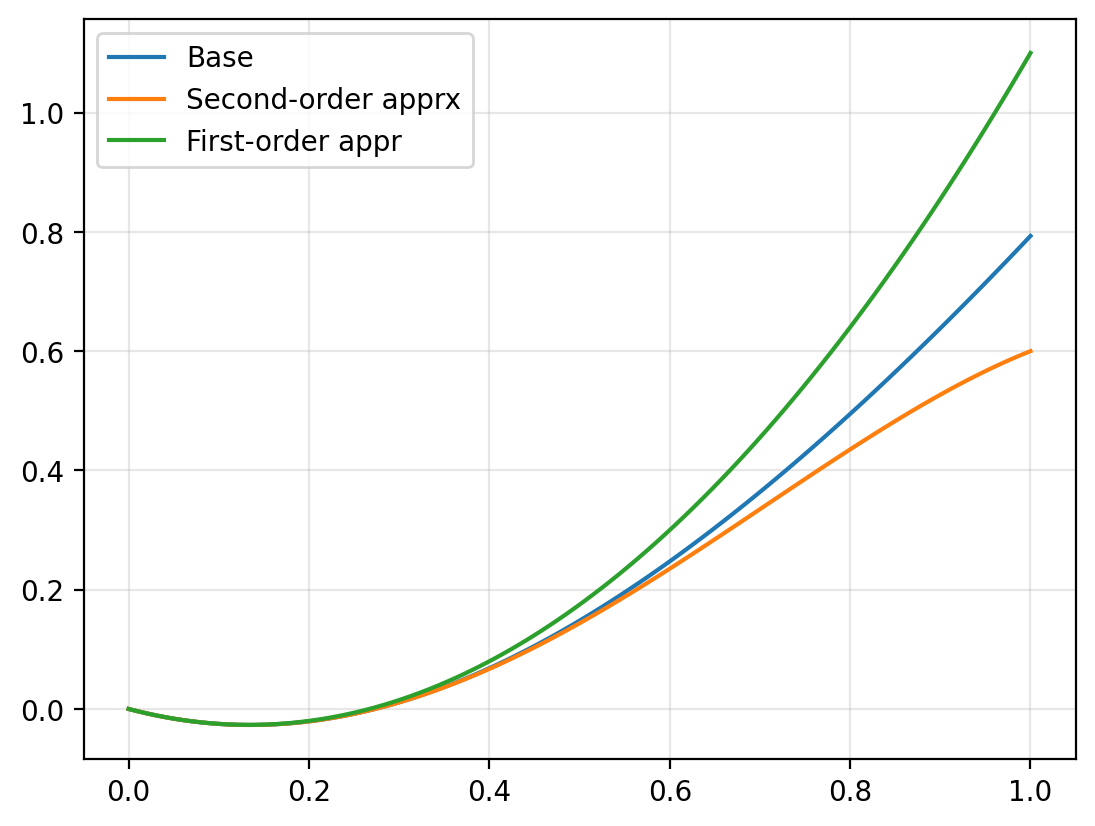

In [130]:
Ixv1 = -lmbdav * (muv + epsv) + lmbdav ** 2 / 2 + np.log(lmbdav ** 2 + 1)
# Second-order approximation
Ixv2 = -lmbdav * (muv + epsv) + lmbdav ** 2 / 2 + lmbdav ** 2 - lmbdav ** 4 / 2
# First-order approximation
Ixv3 = -lmbdav * (muv + epsv) + lmbdav ** 2 / 2 + lmbdav ** 2

plt.plot(lmbdav, Ixv1, label="Base")
plt.plot(lmbdav, Ixv2, label="Second-order apprx")
plt.plot(lmbdav, Ixv3, label="First-order appr")
plt.legend()
plt.grid(alpha=0.3)